In [31]:
import torchvision
from torchvision.models import swin_t
import torch
import cv2

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name
from torchvision.transforms import transforms
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes


MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=MEAN,
                                 std=STD)

transform = transforms.Compose([
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # normalize,
    ])
in_images = []
out_images = []
for image_path in imagenet_stubs.get_image_paths():
    im = PIL.Image.open(image_path).convert('RGB')
    in_images.append(im)
    im = transform(im).numpy()
    out_images.append(im)
images = np.array(out_images)

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [label_to_name(i) for i in list(predictions_["labels"].detach().numpy())]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"].detach().numpy())]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"].detach().numpy())
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 0.3
    text_th = 1
    rect_th = 1

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")


In [37]:
from torch.nn import Module

class SWIN_VIT(Module):

    def __init__(self, model, out_channels):
        super(SWIN_VIT, self).__init__()
        self.model = model
        self.model.out_channels = out_channels
        self.out_channels = out_channels


    def forward(self, x):
        f = self.model(x)
        f = f.reshape(f.shape[0], f.shape[3], f.shape[1], f.shape[2])
        return f

        
vit_model = swin_t(weights='IMAGENET1K_V1')
f_model = SWIN_VIT(vit_model.features, 768)
backbone = f_model
backbone.out_channels = 768


from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import FasterRCNN

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = MultiScaleRoIAlign(featmap_names=['0'],
                                        output_size=7,
                                        sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

_ = model.eval()
'''weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model.load_state_dict(weights.get_state_dict(progress=True))
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)'''

'weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT\nmodel.load_state_dict(weights.get_state_dict(progress=True))\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)'

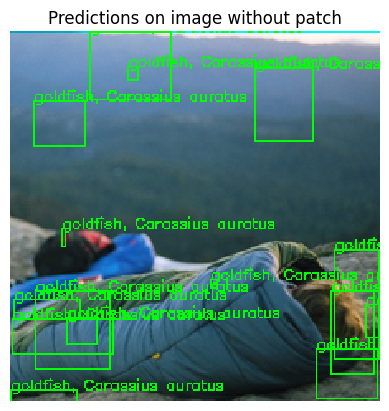

In [148]:
preds = extract_predictions(result[0], 0.65)
im = (test_image[0]*255).numpy().transpose(1,2,0).astype(np.uint)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")